In [1]:
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
from pandas.util.testing import assert_frame_equal

from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.append("..")
from btc_predictor.utils import preproc

In [2]:
df = pd.read_csv("../btc_predictor/datasets/btcusd.csv")

In [3]:
BTCUSD  = preproc(df.copy())

BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))

BTCUSD['baseline_Close'] = BTCUSD.Close.shift(1)
BTCUSD['baseline_log_ret'] = np.log(BTCUSD.baseline_Close) - np.log(BTCUSD.baseline_Close.shift(1))
BTCUSD.dropna(inplace=True)

# 1. Establishing Baseline

In [4]:
np.sqrt(mean_absolute_error(BTCUSD.Close, BTCUSD.baseline_Close))

9.95356055887107

In [5]:
BTCUSD.Close.describe()

count     2031.000000
mean      2928.330074
std       3627.266960
min        178.100000
25%        420.485000
50%        739.250000
75%       5048.250000
max      19497.400000
Name: Close, dtype: float64

Due to the wild fluctuations of BTCUSD prices, from \\$700s at the beginning of our data stream to \\$10,000s towards the end, root mean squared error become an useless metric as the former erorr will miniscule compare to the later errors. Instead, we will look at the RMSE of the normalized and stationary log return.

In [6]:
np.sqrt(mean_squared_error(BTCUSD.log_ret, BTCUSD.baseline_log_ret))

0.05635804810175371

The loss is around 5%, which means the prior day return is an extremely great predictor of current day return. It would be hard to beat that. But the story will change if we look at the directions of the return. The direction of the return is more important than the magnitude of the return, i.e., a trade will be money losing when the direction is wrong.

In [7]:
print("Baseline RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                np.sqrt(mean_squared_error(BTCUSD.log_ret, BTCUSD.baseline_log_ret)),
                                accuracy_score(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret))))

Baseline RMSE is 0.0564, directional accuracy is 0.4884


In [8]:
accuracy_score(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret))

0.48842934515017233

In [9]:
np.sign(BTCUSD.log_ret).unique(), np.sign(BTCUSD.baseline_log_ret).unique()

(array([-1.,  1.,  0.]), array([ 1., -1.,  0.]))

As expected, the direction of prior day log returns is a poor predictor of the direction of current day log returns. While we can obsess with minimizing the RMSE to get a 'better' prediction, we won't be able to capitalize on that prediction until we get the direction right. Thus, it would be economically more important to obtain a better direction prediction than a better magnitude direction.

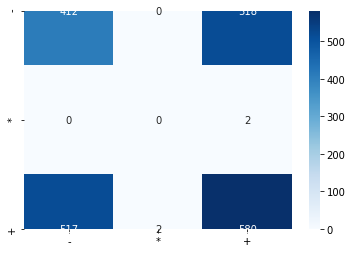

In [10]:
df_cm = pd.DataFrame(confusion_matrix(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret)),  
                     index = [i for i in "-*+"],
                     columns = [i for i in "-*+"])
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

## 1.2 Autoregressive (AR) Model

In [11]:
train = BTCUSD.iloc[0:1700, :]['log_ret']
test = BTCUSD.iloc[1700:, :]['log_ret']

In [12]:
ar = AR(train, freq='D').fit()

y_pred = ar.predict(test.index[0], test.index[-1], dynamic=True)
assert len(y_pred) == test.shape[0]

In [13]:
print("Prediction RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                                        np.sqrt(mean_squared_error(y_pred, test)),
                                                        accuracy_score(np.sign(test), np.sign(y_pred))))

Prediction RMSE is 0.0379, directional accuracy is 0.5559


## 1.3 Univariate Autoregressive integrated Moving Average (ARIMA) Model

In [14]:
def arima_model(train, lag):
    arima = ARIMA(train, order = (lag, 1, 0), freq = 'D').fit(disp=1)
    return arima

In [15]:
def metrics(y, y_pred):
    print("Prediction RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                        np.sqrt(mean_squared_error(y_pred_arima, test)),
                                        accuracy_score(np.sign(test), np.sign(y_pred_arima))))
    pass

lag = list(range(1, 31))
print(lag)

for l in lag:
    arima = arima_model(train, l)
    y_pred_arima = arima.predict(test.index[0], test.index[-1], dynamic=True)
    metrics(test, y_pred_arima)

In [16]:
arima = ARIMA(train, order = (3,1,0), freq = 'D').fit(disp = 0)
y_pred_arima = arima.predict(test.index[0], test.index[-1], dynamic = True)
assert len(y_pred_arima) == test.shape[0]

In [17]:
metrics(test, y_pred_arima)

Prediction RMSE is 0.0378, directional accuracy is 0.5650


In [18]:
print("Prediction RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                                        np.sqrt(mean_squared_error(y_pred_arima, test)),
                                                        accuracy_score(np.sign(test), np.sign(y_pred_arima))))

Prediction RMSE is 0.0378, directional accuracy is 0.5650


That's an improvement to our baseline of 0.056 RMSE and 0.4884 direction accuracy

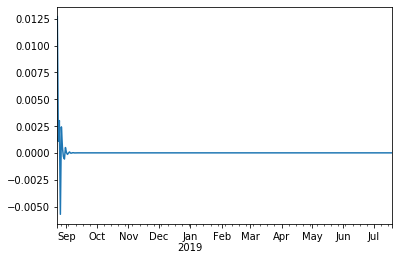

In [36]:
y_pred_arima.plot()

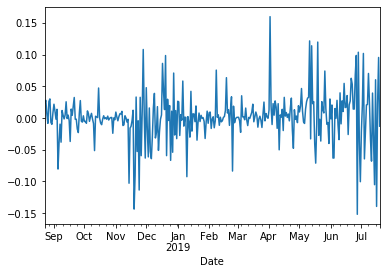

In [37]:
test.plot()

In [19]:
 BTCUSD.iloc[1700:, :].head()

,Open,High,Low,Close,Volume,Market Cap,log_ret,baseline_Close,baseline_log_ret
Date,,,,,,,,,
2018-08-23,6371.34,6546.54,6371.34,6534.88,3.426180e+09,112577436411,0.024502,6376.71,-0.017419
2018-08-24,6551.52,6719.96,6498.64,6719.96,4.097820e+09,115778358839,0.027928,6534.88,0.024502
2018-08-25,6719.95,6789.63,6700.96,6763.19,3.312600e+09,116534497933,0.006412,6719.96,0.027928
2018-08-26,6754.64,6774.75,6620.75,6707.26,3.295500e+09,115585205491,-0.008304,6763.19,0.006412
2018-08-27,6710.80,6884.64,6689.71,6884.64,4.019000e+09,118657885712,0.026102,6707.26,-0.008304


In [20]:
test_df = BTCUSD.iloc[1700:, :].copy()

In [21]:
test_df.head()

,Open,High,Low,Close,Volume,Market Cap,log_ret,baseline_Close,baseline_log_ret
Date,,,,,,,,,
2018-08-23,6371.34,6546.54,6371.34,6534.88,3.426180e+09,112577436411,0.024502,6376.71,-0.017419
2018-08-24,6551.52,6719.96,6498.64,6719.96,4.097820e+09,115778358839,0.027928,6534.88,0.024502
2018-08-25,6719.95,6789.63,6700.96,6763.19,3.312600e+09,116534497933,0.006412,6719.96,0.027928
2018-08-26,6754.64,6774.75,6620.75,6707.26,3.295500e+09,115585205491,-0.008304,6763.19,0.006412
2018-08-27,6710.80,6884.64,6689.71,6884.64,4.019000e+09,118657885712,0.026102,6707.26,-0.008304


To get back prices from log returns, we multiply current period price by predicted next period return `np.exp(log_ret)`.

In [22]:
y_true_s = pd.Series(np.exp(test_df.log_ret.shift(-1)) * test_df.Close)
print(y_true_s)

Date
2018-08-23     6719.96
2018-08-24     6763.19
2018-08-25     6707.26
2018-08-26     6884.64
2018-08-27     7096.28
                ...   
2019-07-15     9477.64
2019-07-16     9693.80
2019-07-17    10666.48
2019-07-18    10530.73
2019-07-19         NaN
Length: 331, dtype: float64


In [23]:
y_arima_pred_s = pd.Series(np.exp(y_pred_arima.shift(-1)) * test_df.Close)
print(y_arima_pred_s)

2018-08-23     6541.908396
2018-08-24     6740.218200
2018-08-25     6724.557747
2018-08-26     6723.543777
2018-08-27     6888.398728
                  ...     
2019-07-15    10895.135227
2019-07-16     9477.679343
2019-07-17     9693.840240
2019-07-18    10666.524278
2019-07-19             NaN
Freq: D, Length: 331, dtype: float64


In [24]:
foo = pd.concat([y_true_s, y_arima_pred_s], axis=1)
foo.columns = ['price', 'pred']

In [25]:
foo.head()

,price,pred
2018-08-23,6719.96,6541.908396
2018-08-24,6763.19,6740.218200
2018-08-25,6707.26,6724.557747
2018-08-26,6884.64,6723.543777
2018-08-27,7096.28,6888.398728


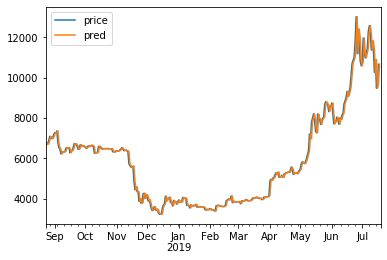

In [26]:
foo.plot()

In [27]:
foo.head(20)

,price,pred
2018-08-23,6719.96,6541.908396
2018-08-24,6763.19,6740.218200
2018-08-25,6707.26,6724.557747
2018-08-26,6884.64,6723.543777
2018-08-27,7096.28,6888.398728
2018-08-28,7047.16,7093.754629
2018-08-29,6978.23,7043.117293
2018-08-30,7037.58,6981.713353
2018-08-31,7193.25,7037.759520
2018-09-01,7272.72,7192.241572


In [29]:
foo.tail(20)

,price,pred
2019-06-30,10583.13,10817.204904
2019-07-01,10801.68,10583.173932
2019-07-02,11961.27,10801.724839
2019-07-03,11215.44,11961.319653
2019-07-04,10978.46,11215.486557
2019-07-05,11208.55,10978.505573
2019-07-06,11450.85,11208.596528
2019-07-07,12285.96,11450.897534
2019-07-08,12573.81,12286.011001
2019-07-09,12156.51,12573.862196


In [28]:
wtf its just time shifting

SyntaxError: invalid syntax (<ipython-input-28-dff023fe9153>, line 1)